In [1]:
import os
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

## Data Exploration 

In [3]:
#Loading the excel file
data = pd.read_excel("Canva_reviews.xlsx")

In [4]:
data.shape

(1500, 13)

In [5]:
data.head(3)

,reviewId,userName,userImage,review,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,Sentiment,Sub Category,Sub Category_test
0,gp:AOqpTOFxf3fttcT5DSvFIn9KPp5FErgH9yC533Fmoxv...,Donna Caritero,https://play-lh.googleusercontent.com/a-/AOh14...,Overall it's really an amazing app. I've been ...,4,528,2.116.0,2021-06-17 07:18:54,Hi Donna. We are sorry that your text or desig...,2021-06-19 21:24:32,Negative,NaN,bug_picture_quality
1,gp:AOqpTOEq6rNIWLnPV4KFTctWvm0mpGEQljtD6mvy1H-...,Soumi Mukhopadhyay,https://play-lh.googleusercontent.com/a-/AOh14...,Hey! Yes I gave a 5 star rating... coz I belie...,5,351,2.116.0,2021-06-17 19:18:28,NaN,NaT,Positive,extremely_happy,NaN
2,gp:AOqpTOE86hSyPRHZgYt28Uk5zGe4FZGb1hkmtFDiYJ2...,Theknown _unknown,https://play-lh.googleusercontent.com/a-/AOh14...,Canva used to be a good app! But recently I've...,1,160,2.116.0,2021-06-23 19:13:28,Hi there. We're sorry to hear that you are hav...,2021-06-26 20:20:56,Negative,saving_downloading_issue,bug_saving_files


<b>Exploring the reviews:</b>

In [6]:
data.loc[13, "review"]

'Unable to save my work. Nothing works :('

In [7]:
data.loc[13, "Sentiment"]

'Negative'

<b>Bar Plot of the Sentiments:</b>

<function matplotlib.pyplot.show(close=None, block=None)>

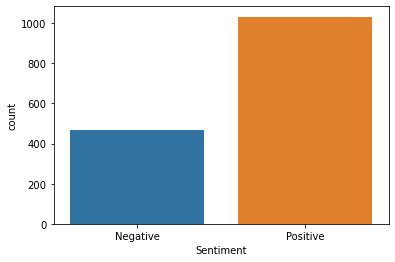

In [8]:
sns.countplot(x = 'Sentiment', data = data)
plt.show

In [9]:
data["Sentiment"].value_counts()

Positive    1032
Negative     468
Name: Sentiment, dtype: int64

This shows that we have 1032 positive reviews as per the sentiments, 468 negative reviews.

<b> Bar plot of Scores: </b>

<function matplotlib.pyplot.show(close=None, block=None)>

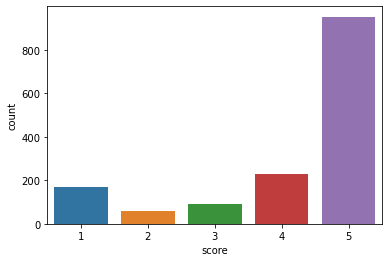

In [10]:
sns.countplot(x = 'score', data=data)
plt.show

In [11]:
data["score"].value_counts()

5    952
4    227
1    170
3     91
2     60
Name: score, dtype: int64

We can see that most of the users have rated the application as 5 or 4 star rating. Few have rated it as 1, 2, and 3 star rating.

<b>Checking relationship between Score and Sentiment: </b>

<function matplotlib.pyplot.show(close=None, block=None)>

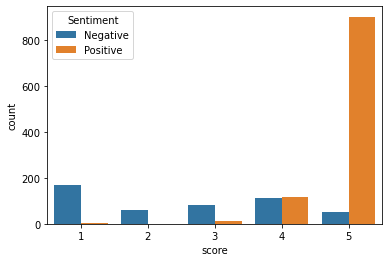

In [12]:
sns.countplot(x = 'score', data=data, hue='Sentiment')
plt.show

It is evident from this plot that when people gave one start rating the number of positive reviews are very low and vice versa. Similarly, when people rated the application as 5 star, the number of negative reviews are very low. In the case of 4 star rating, the number of positive and negative reviews are almost the same.

<b>Finding the relationship between review length and the sentiment: </b>

<b>Finding the length of each review: </b>

In [13]:
data["len"] = data["review"].apply(len)

In [14]:
data["len"].describe()

count    1500.000000
mean       86.468667
std        55.681355
min        20.000000
25%        54.000000
50%        75.000000
75%       102.000000
max       498.000000
Name: len, dtype: float64

<b>Histogram plot of length of review </b>

<function matplotlib.pyplot.show(close=None, block=None)>

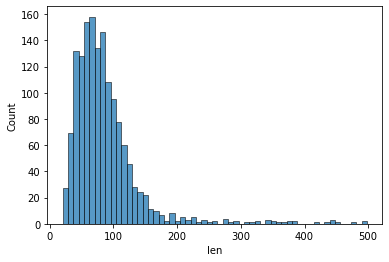

In [15]:
sns.histplot(data['len'])
plt.show

This plot shows that most of the reviews are around the length of 80 words, and very few around 400-500 words.

<b>Plotting the length distribution for different types of Sentiments: </b>

<function matplotlib.pyplot.show(close=None, block=None)>

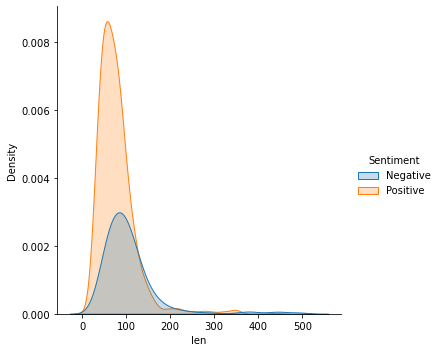

In [16]:
sns.displot(data = data, x="len", hue="Sentiment", kind="kde", fill=True)
plt.show

This plot shows that average length of negative sentiments is slightly higher, but the density of negative sentiments is lower than the postive ones. Postive sentiment curve is little higher, because it has more reviews.

## Tokenization

Tokenization means breaking the sentence into tokens. It is essential for breaking down text in natural language processing for enabling improved ease of learning. There are two types if tokenizers, one is sentence tokenizer and other one is word tokenizer. Sentence tokenizer helps us to break the sentence in two seperate sentences. Whereas, word tokenizer helps us to break the sentence in individual words. 

We only need our review and Sentiment column from this data. So, we only use those two.

In [17]:
data = data[['review', 'Sentiment']]

In [18]:
data.loc[13, 'review']

'Unable to save my work. Nothing works :('

If we use sentence tokenizer here, it will break this sentence into two parts. 

In [19]:
sent_tokenize(data.loc[13, 'review'])

['Unable to save my work.', 'Nothing works :(']

This tokenizer creates a list of sentences

In [20]:
data.loc[1495, "review"]

'Absolutely amazing and a lifesaver for teachers.'

In [21]:
sent_tokenize(data.loc[1495, 'review'])

['Absolutely amazing and a lifesaver for teachers.']

Above results shows that having a sentence tokenizer will not help us a lot, so we will use a word tokenizer.

In [22]:
word_tokenize(data.loc[13, 'review'])

['Unable', 'to', 'save', 'my', 'work', '.', 'Nothing', 'works', ':', '(']

In [23]:
word_tokenize(data.loc[1495, 'review'])

['Absolutely', 'amazing', 'and', 'a', 'lifesaver', 'for', 'teachers', '.']

Everything from the sentence is broken down in different tokens using word_tokenize.

<b> Converting text from uppercase to lowercase</b>

In [24]:
reviews = list(data['review'])
len(reviews)

1500

In [25]:
reviews[13]

'Unable to save my work. Nothing works :('

In [26]:
reviews[1495]

'Absolutely amazing and a lifesaver for teachers.'

In [27]:
reviews_lower = [r.lower() for r in reviews] #using list comprehension
reviews_lower[13]

'unable to save my work. nothing works :('

<b>Tokenizating every single word in the reviews_lower list</b>

In [28]:
tokens = [word_tokenize(r) for r in reviews_lower]
tokens[13]

['unable', 'to', 'save', 'my', 'work', '.', 'nothing', 'works', ':', '(']

## Stopwords Removal

Stop words are common words like ‘the’, ‘and’, ‘I’, etc. that are very frequent in text, and so don’t convey insights into the specific topic of a document. We can remove these stop words from the text in a given corpus to clean up the data, and identify words that are more rare and potentially more relevant to what we’re interested in.

In [29]:
#Using english language stopwords
stopw = stopwords.words('english')

#Displying the common words of english language
stopw[:10]

#Using list comprehension to remove stopwords from tokens list
tokens = [[word for word in t if word not in stopw] for t in tokens]
print(tokens)

[['overall', "'s", 'really', 'amazing', 'app', '.', "'ve", 'using', 'past', '5', 'years', 'however', 'one', 'issue', 'though', 'wanted', 'get', 'address', 'since', 'think', 'issue', 'lasted', 'many', 'years', '?', 'texts', 'blurred', 'zoom', "'s", 'pixelated', '.', 'thought', 'issue', 'occurs', 'mobile', 'apps', 'however', 'also', 'present', 'website', '.', 'please', 'fix', '.', 'still', 'remember', 'time', 'export', 'high', 'definition', 'texts', 'love', 'experience', '.', 'thank', '!'], ['hey', '!', 'yes', 'gave', '5', 'star', 'rating', '...', 'coz', 'believe', 'deserves', '!', 'mostly', 'use', 'desktop', 'version', 'seriously', 'satisfied', 'app', 'android', 'desktop', 'version', '.', 'came', 'thank', 'developers', 'beautiful', 'app', 'facilities', '.', 'literally', 'find', 'almost', 'everything', 'need', 'best', 'part', 'even', 'without', 'premium', 'feature', 'provides', 'us', 'lot', 'many', 'facilities', '.', 'love', '!', 'thank', '..', '!', '❤'], ['canva', 'used', 'good', 'app',

In [30]:
#Removing punctuations using regexptokenizer
print("Tokens before removing punctuation", tokens[13])
tokenizer = RegexpTokenizer(r'\w+')
tokens1 = [["".join(tokenizer.tokenize(word)) for word in t
          if len(tokenizer.tokenize(word)) > 0] for t in tokens]
print("Tokens after removing punctuation", tokens1[13])

Tokens before removing punctuation ['unable', 'save', 'work', '.', 'nothing', 'works', ':', '(']
Tokens after removing punctuation ['unable', 'save', 'work', 'nothing', 'works']


## Stemming

A word stem is part of a word. It is sort of a normalization idea, but linguistic. For example, the stem of the word waiting is wait. We basically get the root word of the word used in the sentence using stemming process. Lancaster stemmer is more aggresive than the porter stemmer. Purpose of stemming is to find different unique words and reduce it's count. This makes training easy in the model.

In [31]:
#Importing both the stemmers
porter = PorterStemmer()
lancaster = LancasterStemmer()

print("Tokens before stemming", tokens1[13])
tokens_stemmed = [[porter.stem(word) for word in t] for t in tokens1]
print("Tokens after stemming", tokens_stemmed[13])

Tokens before stemming ['unable', 'save', 'work', 'nothing', 'works']
Tokens after stemming ['unabl', 'save', 'work', 'noth', 'work']


## Word Count Distribution

Here we will count all the unique tokens by flattening the list of tokens

In [32]:
flat_tokens_stemmed = [word for t in tokens_stemmed for word in t]
print("Length of flattened tokens: ", len(flat_tokens_stemmed), "\n")

#Counting flattened tokens using counter function from collections
counts = Counter(flat_tokens_stemmed)
print("Length of unique counts: ", len(counts), "\n")

#Most common tokens
m_com = counts.most_common(10)
print("Most common tokens: ", m_com, "\n")

Length of flattened tokens:  13782 

Length of unique counts:  1720 

Most common tokens:  [('app', 932), ('use', 474), ('design', 349), ('easi', 293), ('s', 240), ('love', 220), ('good', 219), ('edit', 191), ('make', 190), ('great', 184)] 



## Binary Bag of Words

In [33]:
#Joining the stemmed tokens into sentences
cleaned_reviews = [" ".join(t) for t in tokens_stemmed]
print("Length of cleaned reviews", len(cleaned_reviews), "\n")
print("Printing example of a cleaned review: ", cleaned_reviews[13])

Length of cleaned reviews 1500 

Printing example of a cleaned review:  unabl save work noth work


Whenever we apply any algorithm in NLP, it works on numbers. We cannot directly feed our text into that algorithm. Hence, Bag of Words model is used to preprocess the text by converting it into a bag of words, which keeps a count of the total occurrences of most frequently used words. We're going to use both, binary and actual bag of words model. We'll also add a threshold to check on the words which are appearing below the threshold and to envict them from model training.

In [34]:
#Initializing the count vectorizer
vect = CountVectorizer(binary = True, min_df = 5)

#Creating the sparse matrix of bag of words
X = vect.fit_transform(cleaned_reviews)
print("Shape of sparse matrix: ", X.shape, "\n")

#Finding the unique values in the vocabulary
print("Printing unique values of vocabulary: ", len(vect.vocabulary_), "\n")

#Converting the sparse matrix to array (not recommended for large datasets)
X_array = X.toarray()
print("Shape of X_array: ", X_array.shape, "\n")

Shape of sparse matrix:  (1500, 413) 

Printing unique values of vocabulary:  413 

Shape of X_array:  (1500, 413) 



<b> Converting the depended variables to numbers </b>

In [35]:
#Converting the dependent varaible to 0s and 1s
print(data["Sentiment"])
data["Sentiment"] = data["Sentiment"].apply(lambda x: 1 if x=="Positive" else 0)

y = data["Sentiment"]
y

0       Negative
1       Positive
2       Negative
3       Negative
4       Negative
          ...   
1495    Positive
1496    Negative
1497    Negative
1498    Positive
1499    Positive
Name: Sentiment, Length: 1500, dtype: object


0       0
1       1
2       0
3       0
4       0
       ..
1495    1
1496    0
1497    0
1498    1
1499    1
Name: Sentiment, Length: 1500, dtype: int64

<b>Splitting the data into train and test sets</b>

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

<b>Building the Logistic Regression Model for binary bag of words</b>

In [37]:
model1 = LogisticRegression()

model1.fit(X_train, y_train)

train_pred1 = model1.predict(X_train)

accuracy1 = accuracy_score(y_train, train_pred1) 
print("Accuracy of trained model: ", accuracy1)

test_pred1 = model1.predict(X_test)
accuracy1_test = accuracy_score(y_test, test_pred1)
print("Accuracy of tested model: ", accuracy1_test)

#Saving the model and the vectorizer
with open("C://Users/DELL/Desktop/Binary_count_model/binary_count_vect", "wb") as f:
    pickle.dump(vect, f)
with open("C://Users/DELL/Desktop/Binary_count_model/binary_count_model", "wb") as f:
    pickle.dump(model1, f)

Accuracy of trained model:  0.9608333333333333
Accuracy of tested model:  0.89


## Bag of words without binary

In [38]:
#Initializing the count vectorizer without the binary hyperparameter
vect1 = CountVectorizer(min_df = 5)

#Creating the sparse matrix of bag of words
X1 = vect1.fit_transform(cleaned_reviews)
print("Shape of sparse matrix: ", X1.shape, "\n")

#Finding the unique values in the vocabulary
print("Printing unique values of vocabulary: ", len(vect1.vocabulary_), "\n")

#Converting the sparse matrix to array (not recommended for large datasets)
X1_array = X1.toarray()
print("Shape of X1_array: ", X1_array.shape, "\n")

vect1.get_feature_names().index("work")
print(X1_array[13, 401])

Shape of sparse matrix:  (1500, 413) 

Printing unique values of vocabulary:  413 

Shape of X1_array:  (1500, 413) 

2


Here, we see the value of index with word 'work' is 2 because this word appears twice in the 13th review. This is difference between binary and non-binary bag of words. In binary the index will be always 0 or 1, but non-binary model counts the number of occurences.

<b>Splitting the data into train and test sets</b>

In [39]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size = 0.2, stratify = y, random_state = 42)

<b>Building the Logistic Regression Model for non-binary bag of words</b>

In [40]:
model2 = LogisticRegression()

model2.fit(X1_train, y1_train)

train_pred2 = model2.predict(X1_train)

accuracy2 = accuracy_score(y1_train, train_pred2) 
print("Accuracy of trained model: ", accuracy2)

test_pred2 = model2.predict(X1_test)
accuracy2_test = accuracy_score(y1_test, test_pred2)
print("Accuracy of tested model: ", accuracy2_test)

#Saving the model and the vectorizer
with open("C://Users/DELL/Desktop/Binary_count_model/non_binary_count_vect", "wb") as f:
    pickle.dump(vect1, f)
with open("C://Users/DELL/Desktop/Binary_count_model/non_binary_count_model", "wb") as f:
    pickle.dump(model2, f)

Accuracy of trained model:  0.9566666666666667
Accuracy of tested model:  0.8833333333333333


## N-grams

N-Grams is a set of 1 or more consecutive sequence of items that occur next to each other. As mentioned above, N is a numerical value that implies the n items of sequence of text.

In [41]:
#Initializing the count vectorizer for n_gram 
vect2 = CountVectorizer(min_df = 5, ngram_range=(1, 3))

#Creating the sparse matrix of bag of words
X2 = vect2.fit_transform(cleaned_reviews)
print("Shape of sparse matrix: ", X2.shape, "\n")

#Finding the unique values in the vocabulary
print("Printing unique values of vocabulary: ", len(vect2.vocabulary_), "\n")

#Converting the sparse matrix to array (not recommended for large datasets)
X2_array = X2.toarray()
print("Shape of X2_array: ", X2_array.shape, "\n")

Shape of sparse matrix:  (1500, 666) 

Printing unique values of vocabulary:  666 

Shape of X2_array:  (1500, 666) 



<b>Splitting the data into train and test sets</b>

In [42]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size = 0.2, stratify = y, random_state = 42)

<b>Building the Logistic Regression Model for n_gram bag of words</b>

In [43]:
model3 = LogisticRegression()

model3.fit(X2_train, y2_train)

train_pred3 = model3.predict(X2_train)

accuracy3 = accuracy_score(y2_train, train_pred3) 
print("Accuracy of trained model: ", accuracy3)

test_pred3 = model3.predict(X2_test)
accuracy3_test = accuracy_score(y2_test, test_pred3)
print("Accuracy of tested model: ", accuracy3_test)

#Saving the model and the vectorizer
with open("C://Users/DELL/Desktop/Binary_count_model/n_gram_vect", "wb") as f:
    pickle.dump(vect2, f)
with open("C://Users/DELL/Desktop/Binary_count_model/n_gram_model", "wb") as f:
    pickle.dump(model3, f)

Accuracy of trained model:  0.9716666666666667
Accuracy of tested model:  0.8933333333333333


## TF-IDF

<b> Vectorization techniques which we have used so far considers all wors equally, so we need to define the importance of the words. We define Term Frequency (TF), given a token and a document to get the importance of words for each document. In our case, documents are reviews. We also need to define Inverse Document Frequency (IDF), so that words which occurs uniquely are also weighted properly. After defining both of these terms, the final importance of each word is given by product of TF and IDF.</b>

In [44]:
#Initializing the TF-IDF vectorizer for TF-IDF computation 
vect3 = TfidfVectorizer(min_df = 5)

#Creating the sparse matrix of bag of words
X3 = vect3.fit_transform(cleaned_reviews)
print("Shape of sparse matrix: ", X3.shape)

Shape of sparse matrix:  (1500, 413)


<b>Splitting the data into train and test sets</b>

In [45]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size = 0.2, stratify = y, random_state = 42)

<b>Building the Logistic Regression Model using TF-IDF computation</b>

In [46]:
model4 = LogisticRegression()

model4.fit(X3_train, y3_train)

train_pred4 = model4.predict(X3_train)

accuracy4 = accuracy_score(y3_train, train_pred4) 
print("Accuracy of trained model: ", accuracy4)

test_pred4 = model4.predict(X3_test)
accuracy4_test = accuracy_score(y3_test, test_pred4)
print("Accuracy of tested model: ", accuracy4_test)

#Saving the model and the vectorizer
with open("C://Users/DELL/Desktop/Binary_count_model/tf_idf_vect", "wb") as f:
    pickle.dump(vect3, f)
with open("C://Users/DELL/Desktop/Binary_count_model/tf_idf_model", "wb") as f:
    pickle.dump(model4, f)

Accuracy of trained model:  0.935
Accuracy of tested model:  0.8766666666666667


<b>There is not much of improvement in here when compared with N-grams model, infact N-grams seems to be best till now. </b>

## Prediction for new reviews (not from training set)

In [47]:
#Sample test reviews

test_review1 = "this is a truly amazing app, best for those who havw content but don't know how to express it in a good shareable manner. Thanks Team Canva for such a great app."

test_review2 = 'Its the worst app ever I save my design lts not save'

In [48]:
#Loading the best model (N-gram)
vect5 = pickle.load(open('C://Users/DELL/Desktop/Binary_count_model/n_gram_vect', 'rb'))
model5 = pickle.load(open('C://Users/DELL/Desktop/Binary_count_model/n_gram_model', 'rb'))

#Converting the test reviews to the batch of one record
test_review1 = [test_review1]
print('Test Review 1: ', test_review1, "\n")
test_review2 = [test_review2]
print('Test Review 2: ', test_review2, "\n")

#Converting to the lower case
test_review1 = [r.lower() for r in test_review1]
print('Test Review 1 in lower case: ', test_review1, "\n")
test_review2 = [r.lower() for r in test_review2]
print('Test Review 2 in lower case: ', test_review2, "\n")

Test Review 1:  ["this is a truly amazing app, best for those who havw content but don't know how to express it in a good shareable manner. Thanks Team Canva for such a great app."] 

Test Review 2:  ['Its the worst app ever I save my design lts not save'] 

Test Review 1 in lower case:  ["this is a truly amazing app, best for those who havw content but don't know how to express it in a good shareable manner. thanks team canva for such a great app."] 

Test Review 2 in lower case:  ['its the worst app ever i save my design lts not save'] 



<b> NLP Pre-processing for bag of words model</b>

In [49]:
#Tokenizing the text
tokens1 = [word_tokenize(r) for r in test_review1]
print('Tokens1: ', tokens1, "\n")
tokens2 = [word_tokenize(r) for r in test_review2]
print('Tokens2: ', tokens2, "\n")

#Removing Stopwords
tokens1 = [[word for word in t if word not in stopw] for t in tokens1]
print('Tokens1 after removal of stopwords: ', tokens1, "\n")
tokens2 = [[word for word in t if word not in stopw] for t in tokens2]
print('Tokens2 after removal of stopwords: ', tokens2, "\n")

#Removing Punctuations
tokens1 = [["".join(tokenizer.tokenize(word)) for word in t
          if len(tokenizer.tokenize(word)) > 0] for t in tokens1]
print('Tokens1 after removal of punctuations: ', tokens1, "\n")

tokens2 = [["".join(tokenizer.tokenize(word)) for word in t
          if len(tokenizer.tokenize(word)) > 0] for t in tokens2]
print('Tokens2 after removal of punctuations: ', tokens2, "\n")

#Stemming reviews
tokens1 = [[porter.stem(word) for word in t] for t in tokens1]
print('Tokens1 after stemming process: ', tokens1, "\n")

tokens2 = [[porter.stem(word) for word in t] for t in tokens2]
print('Tokens2 after stemming process: ', tokens2, "\n")

#Joining the tokens to form a sentence
cleaned_reviews1 = [" ".join(review) for review in tokens1]
print('Tokens1 after sentencing process: ', cleaned_reviews1, "\n")

cleaned_reviews2 = [" ".join(review) for review in tokens2]
print('Tokens2 after sentencing process: ', cleaned_reviews2, "\n")

Tokens1:  [['this', 'is', 'a', 'truly', 'amazing', 'app', ',', 'best', 'for', 'those', 'who', 'havw', 'content', 'but', 'do', "n't", 'know', 'how', 'to', 'express', 'it', 'in', 'a', 'good', 'shareable', 'manner', '.', 'thanks', 'team', 'canva', 'for', 'such', 'a', 'great', 'app', '.']] 

Tokens2:  [['its', 'the', 'worst', 'app', 'ever', 'i', 'save', 'my', 'design', 'lts', 'not', 'save']] 

Tokens1 after removal of stopwords:  [['truly', 'amazing', 'app', ',', 'best', 'havw', 'content', "n't", 'know', 'express', 'good', 'shareable', 'manner', '.', 'thanks', 'team', 'canva', 'great', 'app', '.']] 

Tokens2 after removal of stopwords:  [['worst', 'app', 'ever', 'save', 'design', 'lts', 'save']] 

Tokens1 after removal of punctuations:  [['truly', 'amazing', 'app', 'best', 'havw', 'content', 'nt', 'know', 'express', 'good', 'shareable', 'manner', 'thanks', 'team', 'canva', 'great', 'app']] 

Tokens2 after removal of punctuations:  [['worst', 'app', 'ever', 'save', 'design', 'lts', 'save']]

<b> Running the model on test reviews </b>

In [50]:
X4_test = vect5.transform(cleaned_reviews1)
print("Shape of X4_test: ", X4_test.shape)

test1_proba = model5.predict_proba(X4_test)
print("Class probabilities of first review: ", test1_proba)

test1 = model5.predict(X4_test)
print("Class of 1st Test Review: ", test1, "\n")

X5_test = vect5.transform(cleaned_reviews2)
print("Shape of X5_test: ", X5_test.shape)

test2_proba = model5.predict_proba(X5_test)
print("Class probabilities of second review: ", test2_proba)

test2 = model5.predict(X5_test)
print("Class of 2nd Test Review: ", test2)

Shape of X4_test:  (1, 666)
Class probabilities of first review:  [[0.00441452 0.99558548]]
Class of 1st Test Review:  [1] 

Shape of X5_test:  (1, 666)
Class probabilities of second review:  [[0.87775701 0.12224299]]
Class of 2nd Test Review:  [0]


<b>Here, it is clearly proved that test_review1 belongs to postivie class, and test_review2 belongs to negative class.</b>